# Covid-19 Radiology Segmentation & Classification
COMP 478 Project
<br>
Jeremy Gaudet
<br>
ID: 40045224
<br>
April 25, 2021

In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
from PIL import Image

import sys
import os
from glob import glob

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# sys.path.append('/content/gdrive/My Drive/COMP478 Project/')
# %cd /content/gdrive/My Drive/COMP478 Project/

## Global variables

In [3]:
PATH = '/Users/jeremygaudet/Downloads/COVID-19_Radiography_Dataset'
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)
IMAGE_WIDTH = IMAGE_SIZE[0]
IMAGE_HEIGHT = IMAGE_SIZE[1]
NUM_CLASSES = 4

## Loading the images

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    # color_mode="grayscale",
    # label_mode="categorical"
    )

Found 21165 files belonging to 4 classes.
Using 16932 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    # color_mode="grayscale",
    # label_mode="categorical"
    )

Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


In [6]:
CLASS_NAMES = train_ds.class_names
print(CLASS_NAMES)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


# Data Analysis

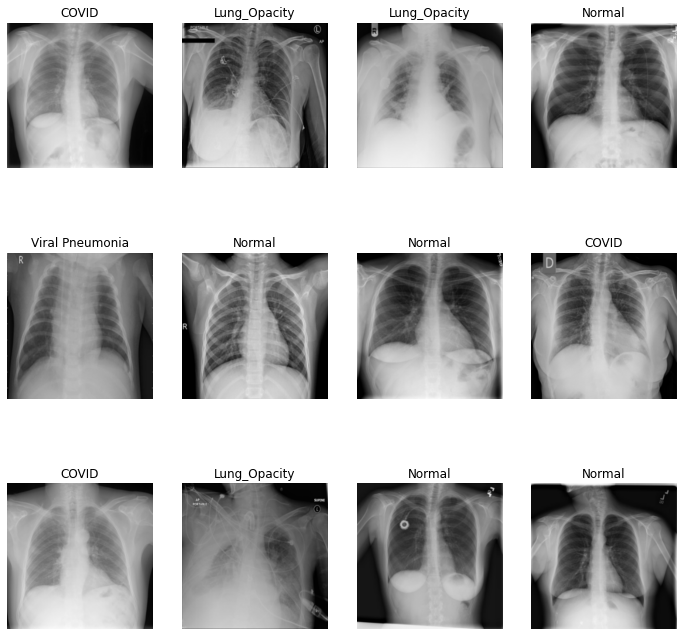

In [22]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


# Image Processing

In [33]:
from keras import layers

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMAGE_HEIGHT, 
                                                              IMAGE_WIDTH,
                                                              3)),
    layers.experimental.preprocessing.RandomContrast(0.02, seed=1337),
  ]
)

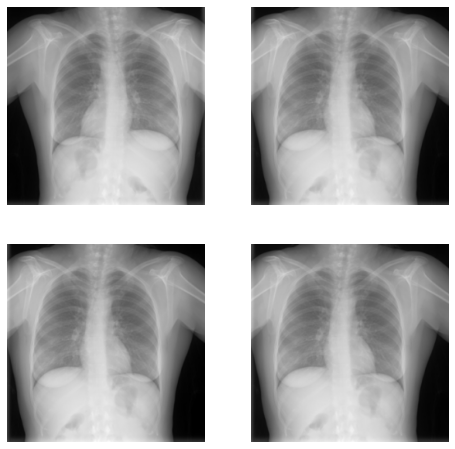

In [34]:
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
    for i in range(4):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")

# Classification

In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
model = tf.keras.Sequential([ 
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES)
])

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 32)       

In [15]:
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
530/530 [==============================] - 178s 333ms/step - loss: 0.8896 - accuracy: 0.6288 - val_loss: 0.5934 - val_accuracy: 0.7772
Epoch 2/10
530/530 [==============================] - 183s 344ms/step - loss: 0.5548 - accuracy: 0.7816 - val_loss: 0.5194 - val_accuracy: 0.8018
Epoch 3/10
530/530 [==============================] - 183s 343ms/step - loss: 0.4561 - accuracy: 0.8222 - val_loss: 0.4898 - val_accuracy: 0.8164
Epoch 4/10
530/530 [==============================] - 183s 344ms/step - loss: 0.3877 - accuracy: 0.8519 - val_loss: 0.5149 - val_accuracy: 0.8197
Epoch 5/10
530/530 [==============================] - 184s 346ms/step - loss: 0.3276 - accuracy: 0.8775 - val_loss: 0.4648 - val_accuracy: 0.8365
Epoch 6/10
530/530 [==============================] - 179s 335ms/step - loss: 0.2957 - accuracy: 0.8903 - val_loss: 0.5131 - val_accuracy: 0.8261
Epoch 7/10
530/530 [==============================] - 185s 347ms/step - loss: 0.2568 - accuracy: 0.9069 - val_loss: 0.4341 -

In [16]:
# Save the entire model to a HDF5 file.
# !mkdir models/
# model.save('models/covid_lung_model_256_preprocess_drop.h5')

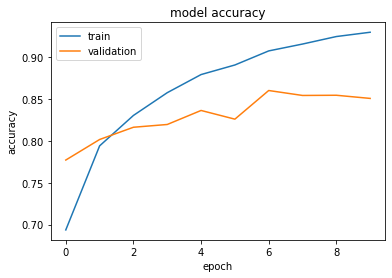

In [17]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

This image is Lung_Opacity with 59.15% confidence


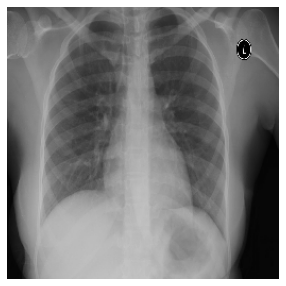

In [21]:
# test_image_path = "/Users/jeremygaudet/Downloads/istockphoto-173883249-612x612.jpg"
# test_image_path = "/Users/jeremygaudet/Downloads/c3-1-e1586266398823.jpg.webp"
test_image_path = "/Users/jeremygaudet/Downloads/normal-lung-xray-15x10-by-Yale-Rosen.jpg"

img = keras.preprocessing.image.load_img(test_image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# Plot image
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis("off")

# Load a model
# model_256 = keras.models.load_model('covid_lung_model.h5')

# Preprocess image
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
# Make predictions on images
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
# Get index for highest confidence class
idx = np.argmax(score)

print(f'This image is {CLASS_NAMES[idx]} with {score[idx]*100:0.2f}% confidence')